# Procesamiento de Lenguaje Natural I

**Autor:** Gonzalo G. Fernandez

Clase 6: Modelos Seq2Seq, traductores y bots conversacionales

## Consigna desafío 4
Contruir QA Bot basado en el ejemplo visto en clase del traductor pero con un dataset QA.

![](./imgs/qa_bot-architecture.png)

Requerimientos del notebook:

In [116]:
import os
import gdown
import logging
import json
import pickle
from pathlib import Path
import re

import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model

## Resolución

### Carga de dataset QA

Descarga del dataset QA proveído por la cátedra.

In [117]:
DATASET_NAME = "data_volunteers.json"
DATASET_PATH = os.path.join("data", DATASET_NAME)

if not os.path.exists(DATASET_PATH):
    if os.access(DATASET_NAME, os.F_OK) is False:
        url = "https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download"
        gdown.download(url, DATASET_PATH, quiet=False)
    else:
        print("El dataset ya se encuentra descargado")

Carga del dataset en memoria.

In [118]:
with open(DATASET_PATH) as f:
    data = json.load(f)
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

Preparación del dataset en la estructura adecuada.

In [119]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30


def clean_text(txt):
    txt = txt.lower()
    txt.replace("'d", " had")
    txt.replace("'s", " is")
    txt.replace("'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r"\W+", " ", txt)
    return txt


for line in data:
    for i in range(len(line["dialog"]) - 1):
        chat_in = clean_text(line["dialog"][i]["text"])
        chat_out = clean_text(line["dialog"][i + 1]["text"])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        output_sentence = output + " <eos>"
        output_sentence_input = "<sos> " + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


Mejoras al tratamiento de los datos:

In [120]:
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9']+", " ", text)
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

[nltk_data] Downloading package wordnet to /home/ggf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Preprocesamiento

Preprocesamiento necesario para obtener:

- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [121]:
MAX_VOCAB_SIZE = 10000

Tokenizador de entrada:

In [122]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


Tokenizador de salida:

In [123]:
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


In [124]:
max_input_len = 16
max_out_len = 18

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [125]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 16)
decoder_input_sequences shape: (6033, 18)


La última capa del modelo (softmax) necesita que los valores de salida del decoder (decoder_sequences) estén en formato oneHotEncoder.
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [126]:
decoder_output_sequences = pad_sequences(
    output_integer_seq, maxlen=max_out_len, padding="post"
)
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 18, 1807)

### Embeddings
Se utiliza los embeddings de Glove para transformar los tokens de entrada en vectores

In [127]:
EMBEDDINGS_NAME = "gloveembedding.pkl"
EMBEDDINGS_PATH = os.path.join("data", EMBEDDINGS_NAME)

if not os.path.exists(EMBEDDINGS_PATH):
    if os.access(EMBEDDINGS_NAME, os.F_OK) is False:
        url = "https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download"
        gdown.download(url, EMBEDDINGS_PATH, quiet=False)
    else:
        print("Los embeddings gloveembedding.pkl ya están descargados")

In [128]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), "Words embedding not available"
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings["word"], index))
        self.idx2word = dict(zip(index, self.embeddings["word"]))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]["embedding"]

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, "-1") for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            "loading words embeddings from pickle {}".format(self.PKL_PATH)
        )
        max_bytes = 2**28 - 1  # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, "rb") as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug("words embeddings loaded")
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            "converting and loading words embeddings from text file {}".format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [
            ("word", np.dtype("U" + str(self.WORD_MAX_SIZE))),
            ("embedding", np.float32, (self.N_FEATURES,)),
        ]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(
            self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8"
        ) as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:])
                for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [("null_embedding", np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure,
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1  # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, "wb") as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx : idx + max_bytes])
        self.logger.debug("words embeddings loaded")
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = "glove.twitter.27B.50d.txt"
    PKL_PATH = EMBEDDINGS_PATH
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [129]:
model_embeddings = GloveEmbeddings()

In [130]:
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) + 1 # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
embedding_matrix.shape

number of null word embeddings: 38


(1800, 50)

### Entrenamiento del modelo
Entrenamiento de un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores.

In [131]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

# encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
    input_dim=nb_words,  # definido en el Tokenizador
    output_dim=embed_dim,  # dimensión de los embeddings utilizados
    input_length=max_input_len,  # tamaño máximo de la secuencia de entrada
    weights=[embedding_matrix],  # matrix de embeddings
    trainable=False,
)  # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output, output_dim=n_units, input_length=max_out_len
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Attention
attention = Attention()
context_vector = attention([decoder_outputs, encoder_outputs])

# Concatenate context and decoder outputs
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Dense
decoder_dense = Dense(num_words_output, activation="softmax")
decoder_outputs = decoder_dense(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

/home/ggf/workspace/ceia/ceia-nlp1/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 16, 50)    │     90,000 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 18, 128)   │    231,296 │ input_layer_30[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 16, 128), │     91,648 │ embedding_13[0][… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 18, 128), │    131,584 │ embedding_14[0][… │
│                     │ (None, 128),      │            │ lstm_12[0][1],    │
│                     │ (None, 128)]      │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 18, 128)   │          0 │ lstm_13[0][0],    │
│ (Attention)         │                   │            │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 18, 256)   │          0 │ attention_5[0][0… │
│ (Concatenate)       │                   │            │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 18, 1807)  │    464,399 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,008,927 (3.85 MB)

 Trainable params: 918,927 (3.51 MB)

 Non-trainable params: 90,000 (351.56 KB)

Arquitectura de modelo completo:

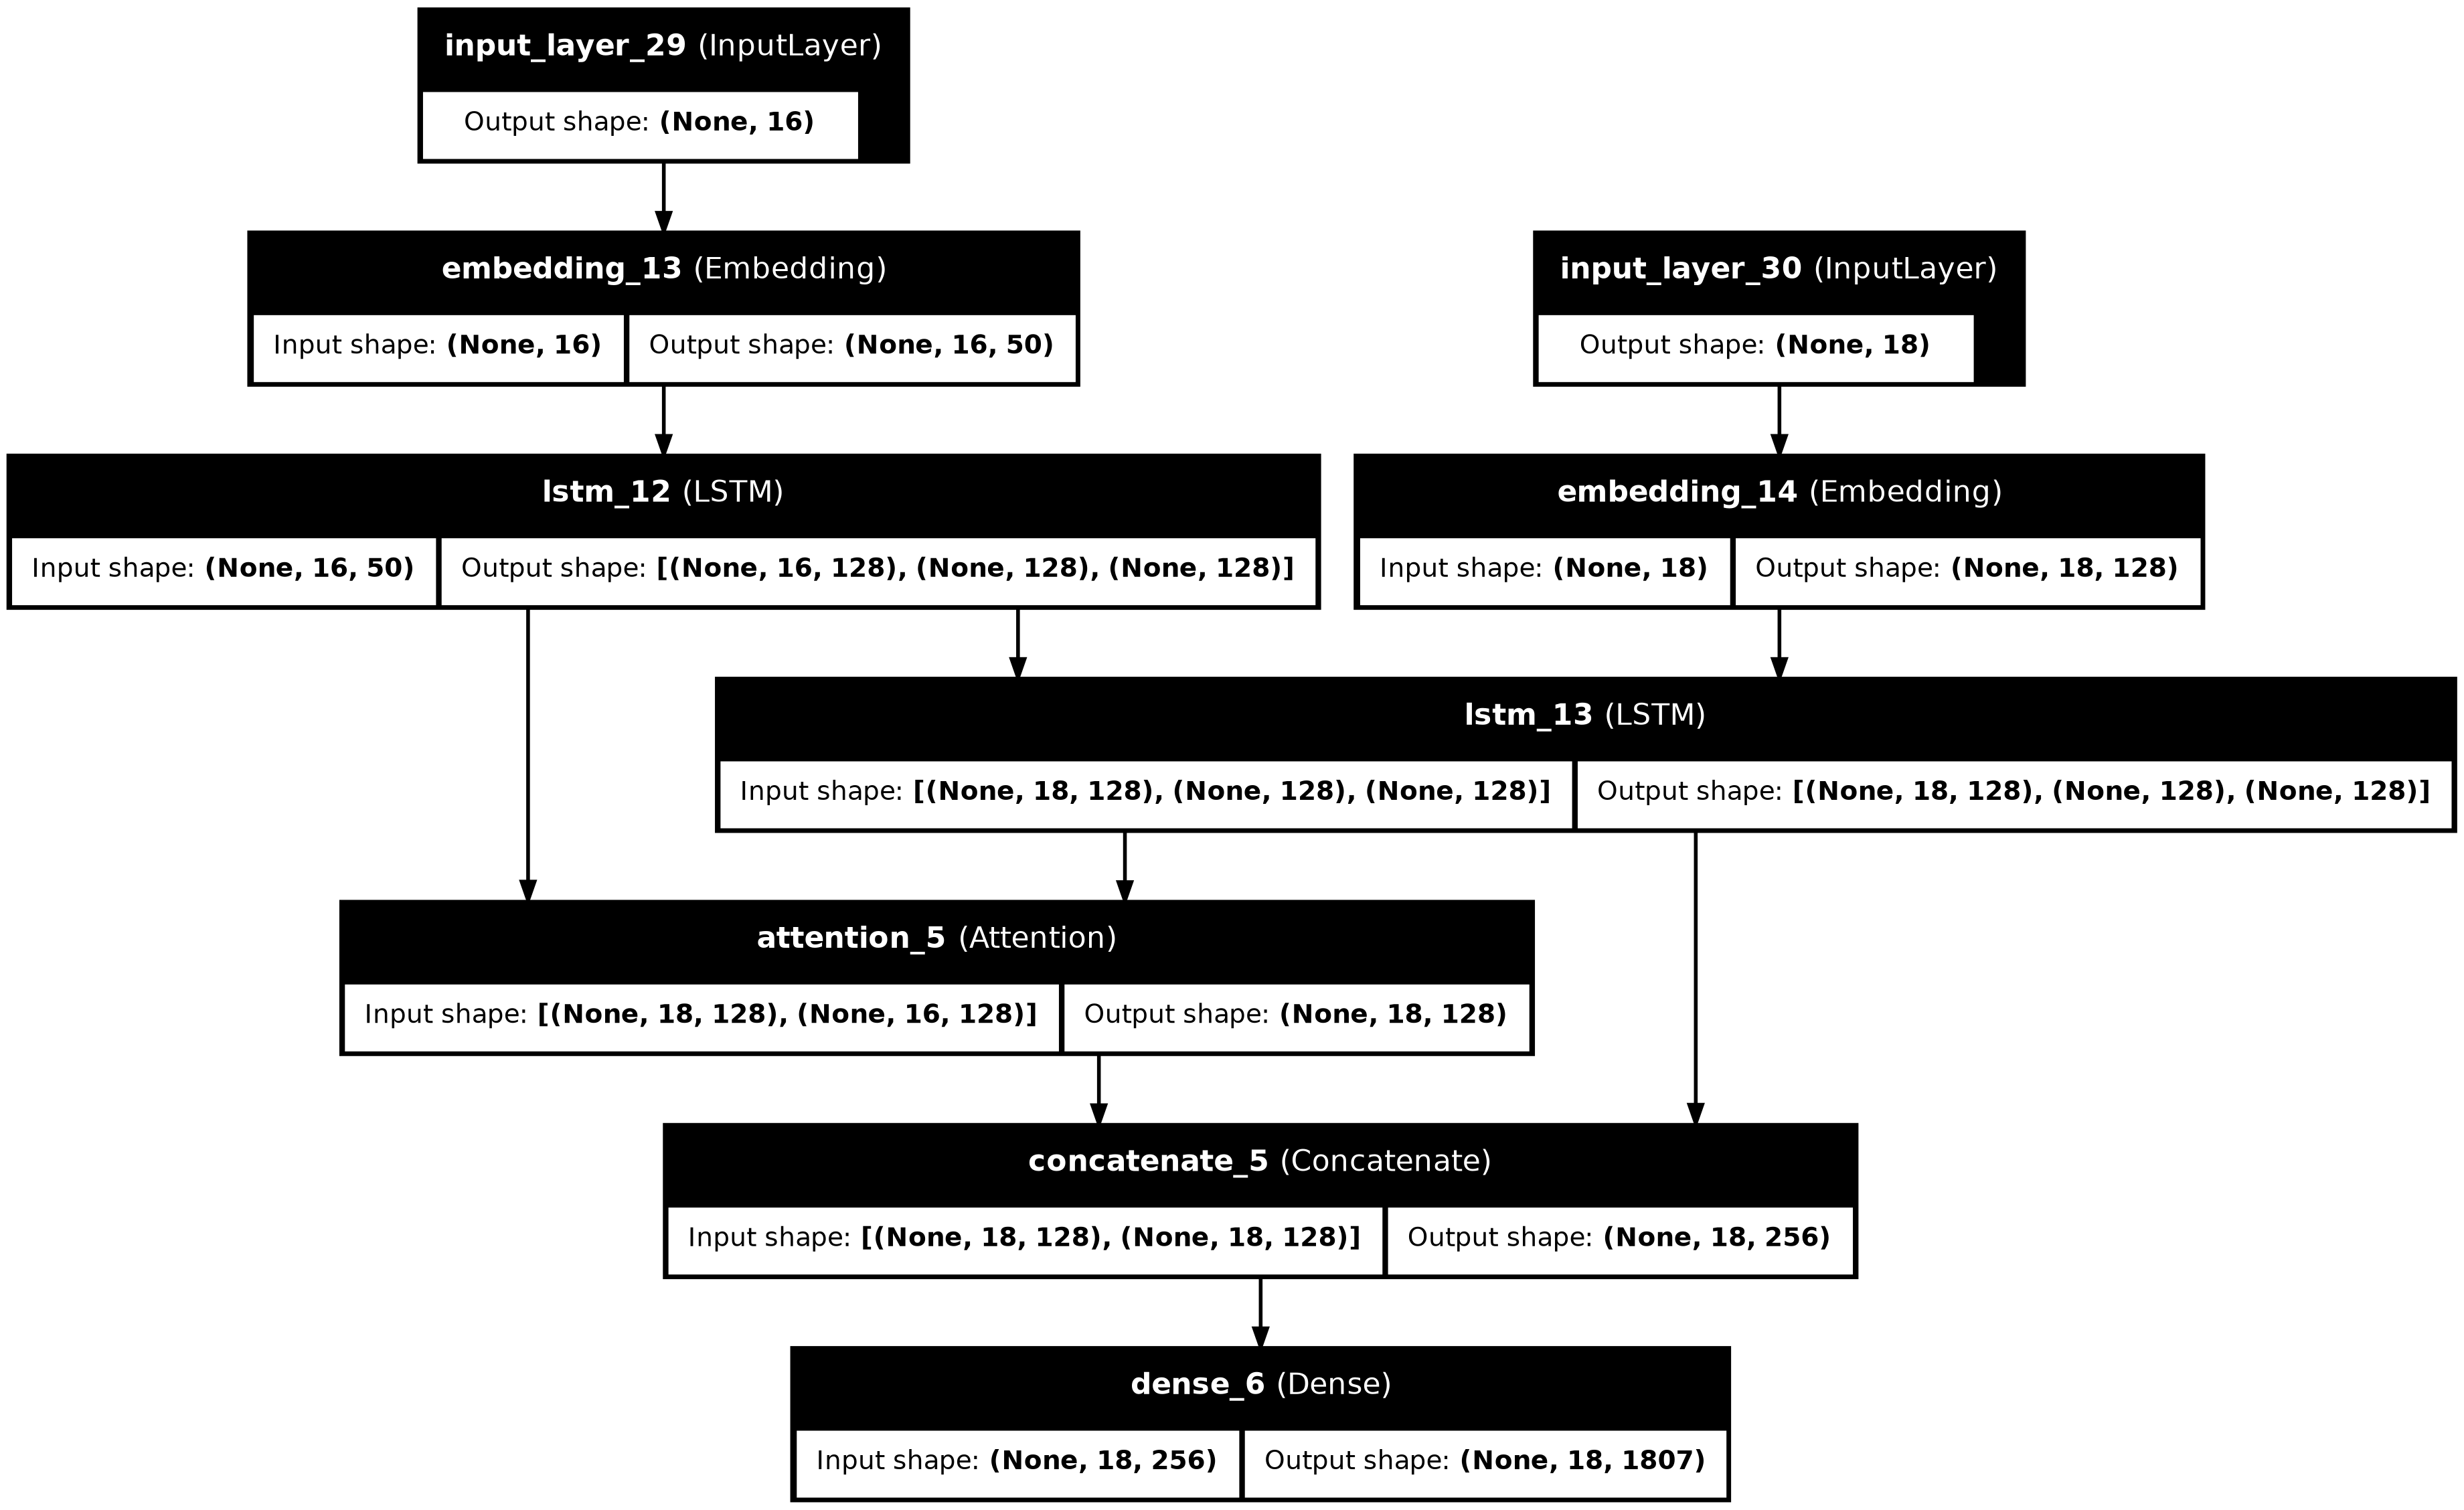

In [132]:
plot_model(model, to_file="output/model_plot.png", show_shapes=True, show_layer_names=True)

Arquitectura del encoder:

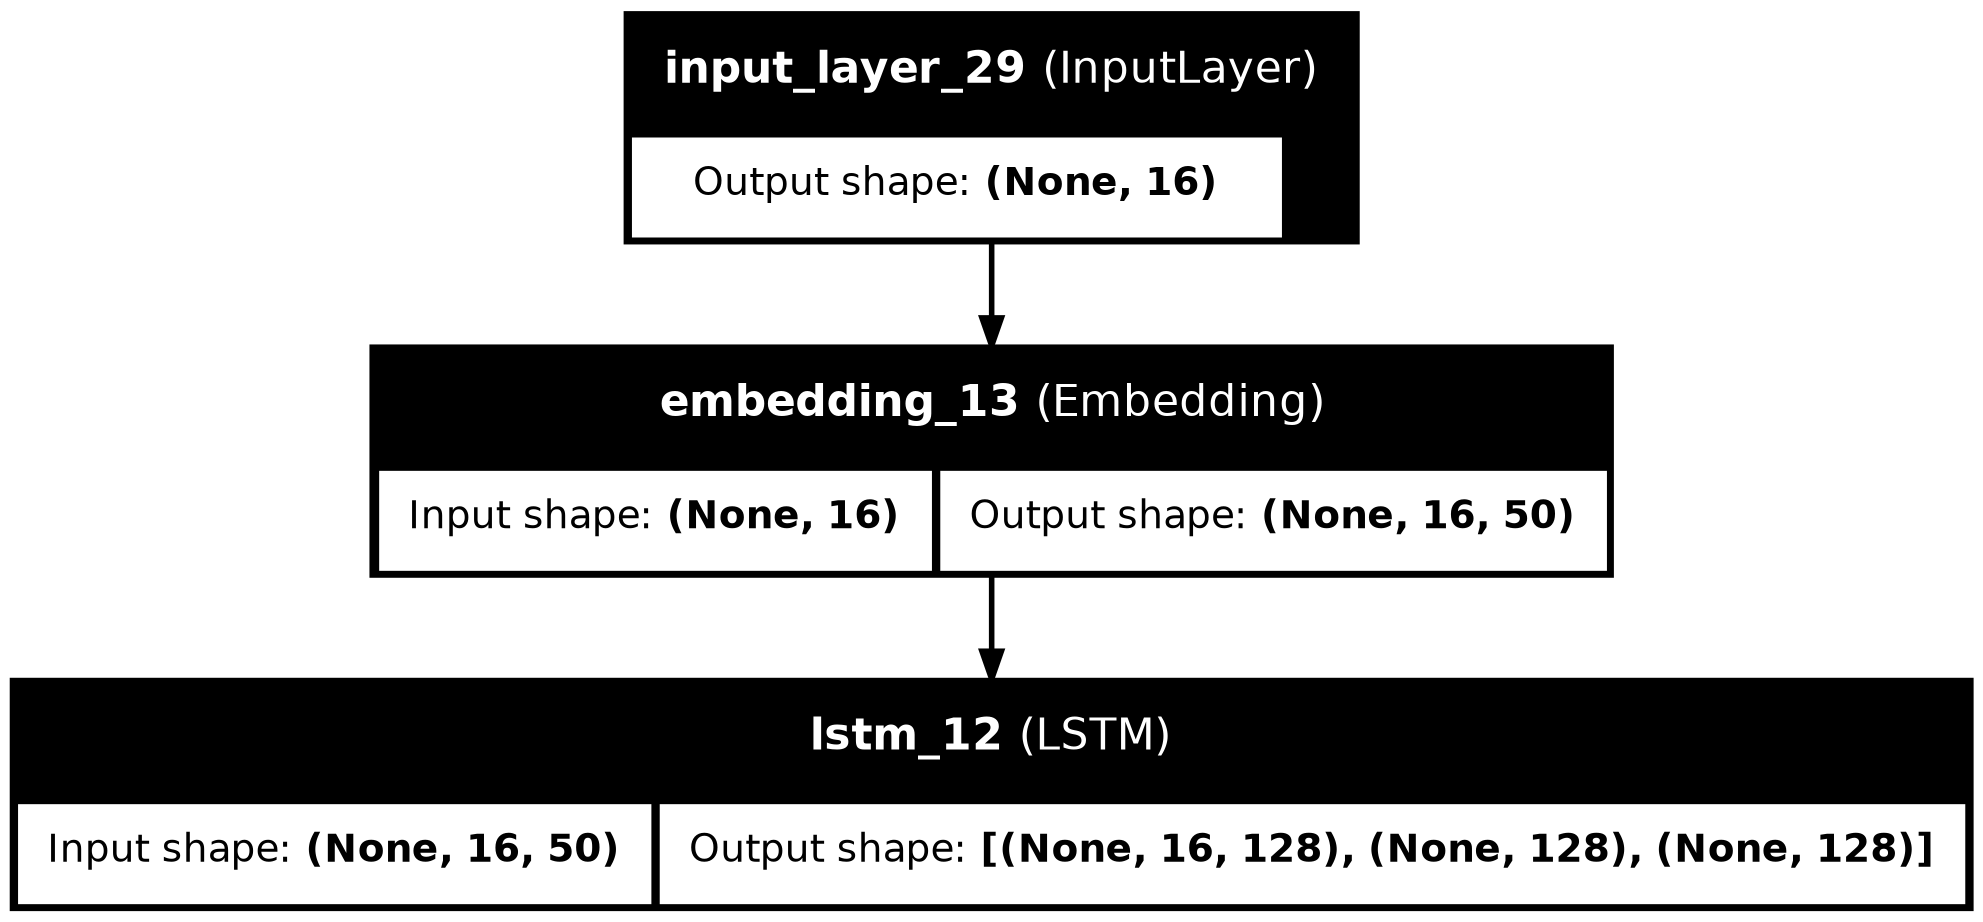

In [133]:
# encoder_model = Model(encoder_inputs, encoder_states)
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])
plot_model(
    encoder_model, to_file="output/encoder_plot.png", show_shapes=True, show_layer_names=True
)

Arquitectura del decoder:

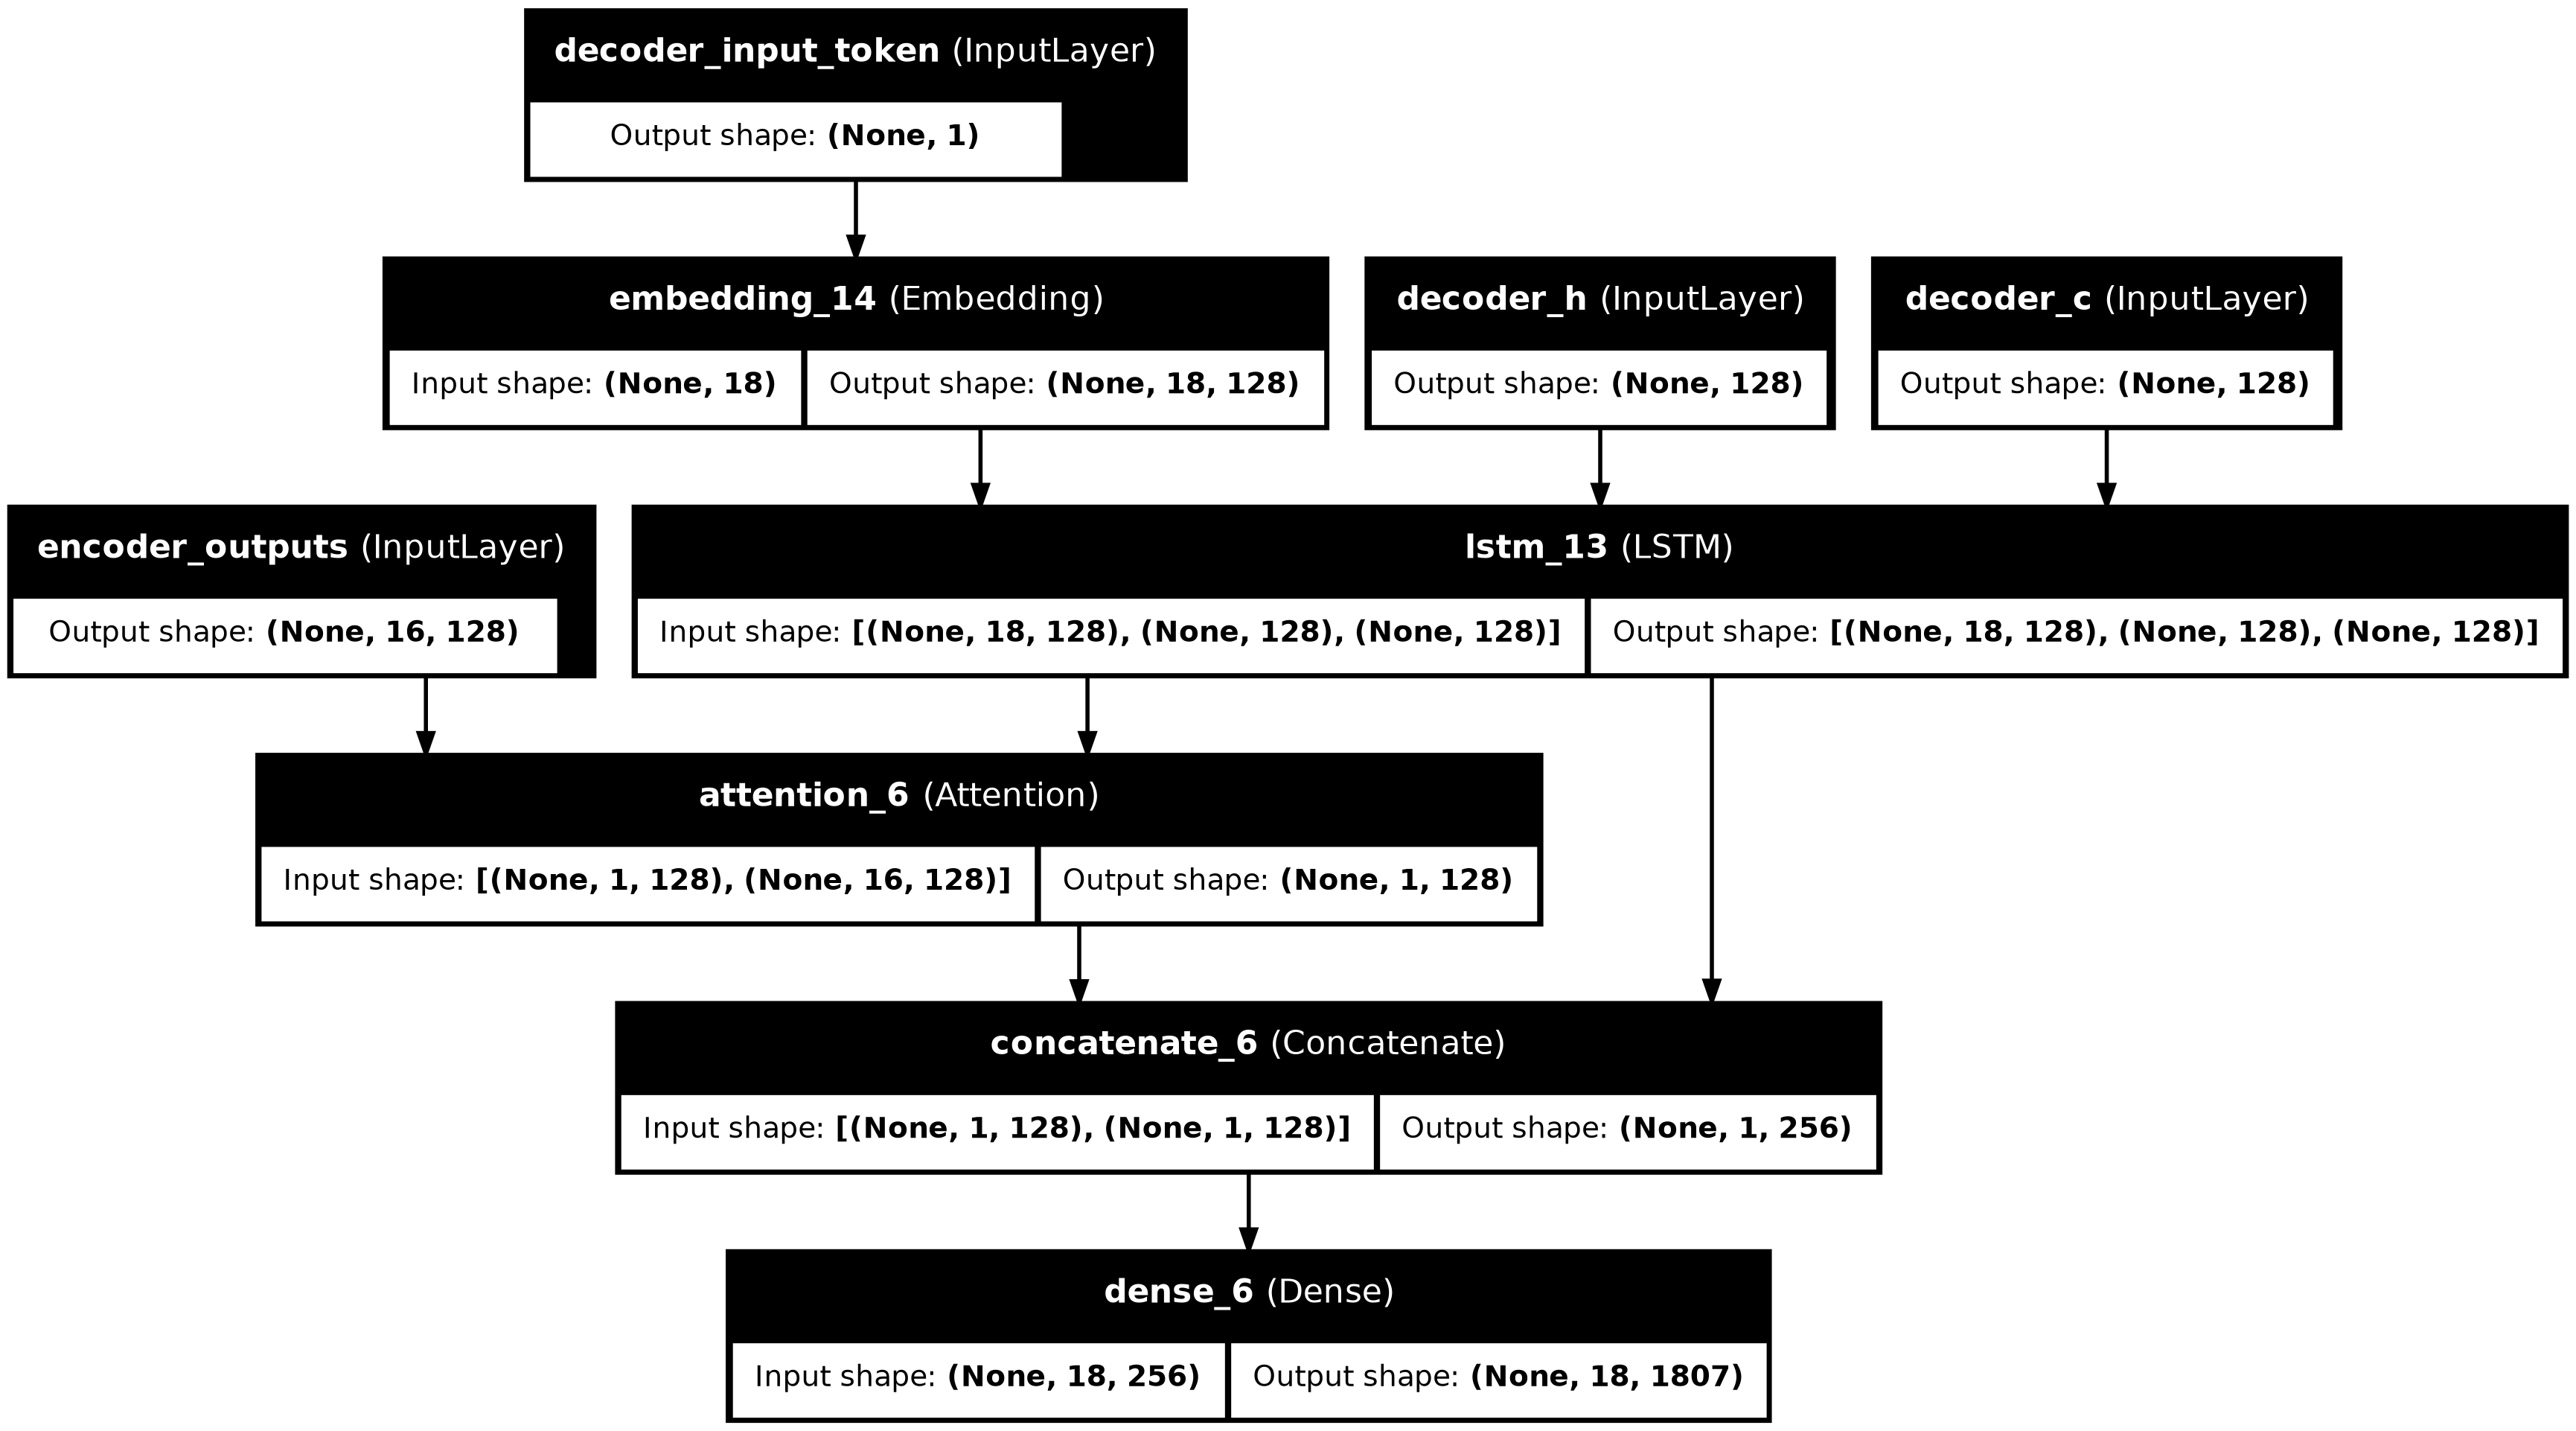

In [134]:
decoder_inputs_single = Input(shape=(1,), name="decoder_input_token")

decoder_state_input_h = Input(shape=(n_units,), name="decoder_h")
decoder_state_input_c = Input(shape=(n_units,), name="decoder_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

encoder_outputs_inf = Input(shape=(max_input_len, n_units), name="encoder_outputs")

decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs
)

attention_inf = Attention()
context_vector = attention_inf([decoder_outputs, encoder_outputs_inf])

decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

decoder_outputs_final = decoder_dense(decoder_combined_context)

decoder_model = Model(
    [decoder_inputs_single, encoder_outputs_inf] + decoder_states_inputs,
    [decoder_outputs_final, state_h, state_c],
)

plot_model(
    decoder_model,
    to_file="output/decoder_plot.png",
    show_shapes=True,
    show_layer_names=True,
)

In [135]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15,
    validation_split=0.2,
)

Epoch 1/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.7052 - loss: 3.0033 - val_accuracy: 0.7957 - val_loss: 1.2321
Epoch 2/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.7935 - loss: 1.1262 - val_accuracy: 0.8158 - val_loss: 1.1376
Epoch 3/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8325 - loss: 0.9920 - val_accuracy: 0.8300 - val_loss: 1.0559
Epoch 4/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8403 - loss: 0.9078 - val_accuracy: 0.8362 - val_loss: 1.0053
Epoch 5/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8483 - loss: 0.8391 - val_accuracy: 0.8409 - val_loss: 0.9727
Epoch 6/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8558 - loss: 0.7822 - val_accuracy: 0.8435 - val_loss: 0.9513
Epoch 7/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8618 - loss: 0.7306 - val_accuracy: 0.8453 - val_loss: 0.9358
Epoch 8/15
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8629 - loss: 0.7178 - 

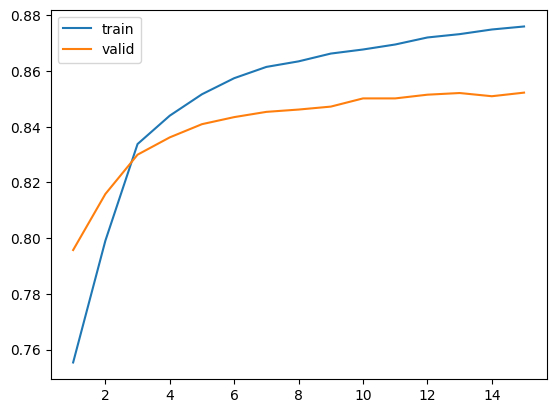

In [136]:
epoch_count = range(1, len(hist.history["accuracy"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="train")
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="valid")
plt.show()

### Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [137]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [138]:
def get_reply(input_seq):
    """Genera una respuesta usando atención."""

    input_seq = pad_sequences(
        input_tokenizer.texts_to_sequences([clean_text(input_seq)]),
        maxlen=max_input_len,
        padding="post",
    )

    encoder_outputs_val, state_h_val, state_c_val = encoder_model.predict(input_seq)

    target_seq = np.array([[word2idx_outputs["<sos>"]]])

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq, encoder_outputs_val, state_h_val, state_c_val]
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2word_target.get(sampled_token_index, "")

        if sampled_word == "<eos>" or len(decoded_sentence) > max_out_len:
            stop_condition = True
        else:
            decoded_sentence.append(sampled_word)

        target_seq = np.array([[sampled_token_index]])
        state_h_val, state_c_val = h, c

    return " ".join(decoded_sentence)

In [141]:
print(get_reply("What do you do in your free time?"))
print(get_reply("I'm an engineer, and you?"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
i m a student
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
i am a student
